Columns: ['date', 'close', 'volume', 'open', 'high', 'low']
Epoch 1/70 | Train MSE: 319.62 | Train MAE: 15.70 | Train Accuracy: 91.35% | Train R²: -2.0910
Epoch 2/70 | Train MSE: 218.90 | Train MAE: 13.44 | Train Accuracy: 92.59% | Train R²: -1.1170
Epoch 3/70 | Train MSE: 138.13 | Train MAE: 11.11 | Train Accuracy: 93.88% | Train R²: -0.3359
Epoch 4/70 | Train MSE: 79.42 | Train MAE: 8.62 | Train Accuracy: 95.25% | Train R²: 0.2319
Epoch 5/70 | Train MSE: 53.51 | Train MAE: 5.81 | Train Accuracy: 96.80% | Train R²: 0.4825
Epoch 6/70 | Train MSE: 72.49 | Train MAE: 5.58 | Train Accuracy: 96.92% | Train R²: 0.2990
Epoch 7/70 | Train MSE: 91.57 | Train MAE: 7.15 | Train Accuracy: 96.06% | Train R²: 0.1144
Epoch 8/70 | Train MSE: 80.49 | Train MAE: 6.53 | Train Accuracy: 96.40% | Train R²: 0.2216
Epoch 9/70 | Train MSE: 59.64 | Train MAE: 5.05 | Train Accuracy: 97.22% | Train R²: 0.4232
Epoch 10/70 | Train MSE: 44.96 | Train MAE: 4.09 | Train Accuracy: 97.75% | Train R²: 0.5652
Epoch 11/7

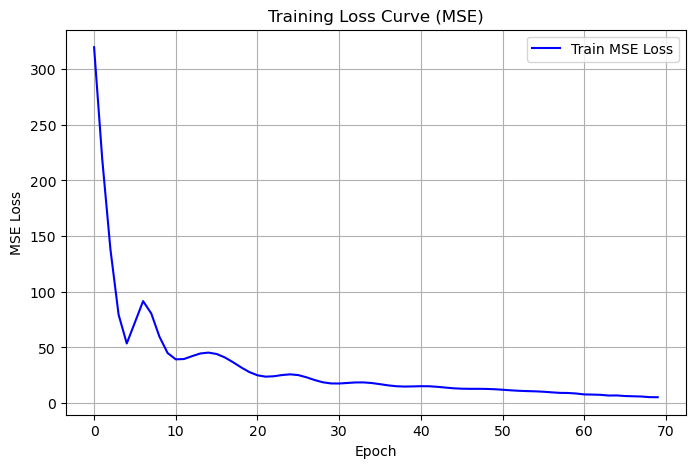

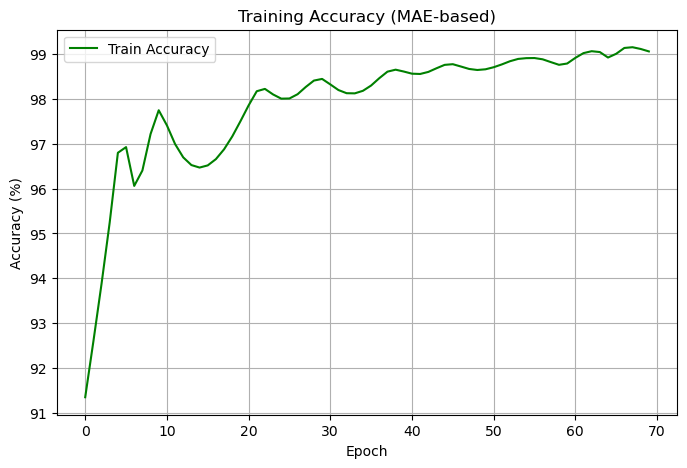


Test MSE: 13.05 | Test MAE: 3.42 | Test Accuracy: 98.22% | Test R²: -4.5561


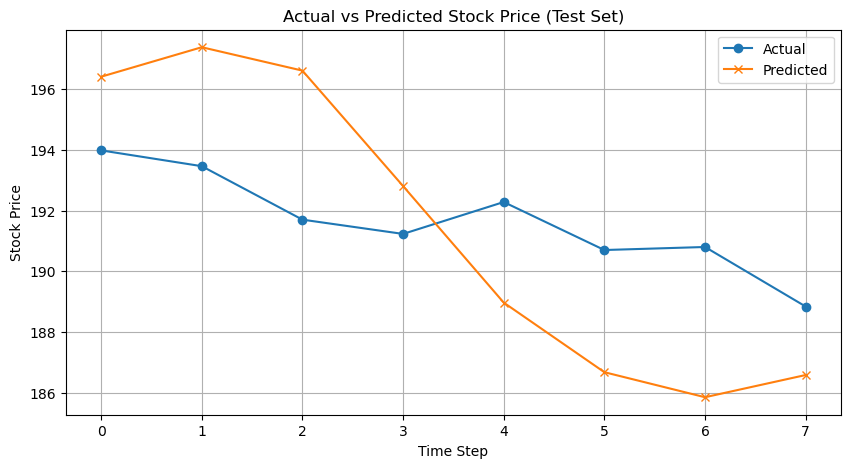


Predicted next stock price: $185.90


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import random

# Set seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load dataset
file_path = "HistoricalQuotes.csv"
df = pd.read_csv(file_path)

# Clean column names
df.columns = df.columns.str.strip().str.lower()
print("Columns:", df.columns.tolist())

# Check required columns
required_columns = ['date', 'open', 'high', 'low', 'close', 'volume']
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    raise KeyError(f"Missing columns in CSV: {missing_cols}")

# Convert date and clean numeric columns
df['date'] = pd.to_datetime(df['date'])
for col in ['open', 'high', 'low', 'close', 'volume']:
    df[col] = df[col].astype(str).str.replace(r'[\$,]', '', regex=True).astype(float)

# Sort and index
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

# Feature/target setup
features = ['open', 'high', 'low', 'volume']
target_col = ['close']

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[target_col])

# Create sequences
def create_sequences(X, y, time_step):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_step):
        X_seq.append(X[i:i + time_step])
        y_seq.append(y[i + time_step])
    return np.array(X_seq), np.array(y_seq)

time_step = 25
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_step)

X_seq = torch.tensor(X_seq, dtype=torch.float32)
y_seq = torch.tensor(y_seq, dtype=torch.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Define RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

input_size = len(features)
hidden_size = 128
output_size = 1
model = RNN(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracy_scores, train_r2_scores = [], [], []

# Train loop
epochs = 70
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        train_pred = model(X_train).detach().numpy()
        train_true = y_train.detach().numpy()

        train_pred_inv = scaler_y.inverse_transform(train_pred)
        train_true_inv = scaler_y.inverse_transform(train_true)

        train_mse = mean_squared_error(train_true_inv, train_pred_inv)
        train_mae = mean_absolute_error(train_true_inv, train_pred_inv)
        train_r2 = r2_score(train_true_inv, train_pred_inv)
        train_accuracy = 100 * (1 - train_mae / np.mean(train_true_inv))

        train_losses.append(train_mse)
        train_accuracy_scores.append(train_accuracy)
        train_r2_scores.append(train_r2)

        print(f"Epoch {epoch+1}/{epochs} | Train MSE: {train_mse:.2f} | Train MAE: {train_mae:.2f} | "
              f"Train Accuracy: {train_accuracy:.2f}% | Train R²: {train_r2:.4f}")

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train MSE Loss", color='blue')
plt.title("Training Loss Curve (MSE)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_accuracy_scores, label="Train Accuracy", color='green')
plt.title("Training Accuracy (MAE-based)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

# Evaluate on test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).detach().numpy()
    y_test_true = y_test.detach().numpy()

    y_pred_test_inv = scaler_y.inverse_transform(y_pred_test)
    y_test_true_inv = scaler_y.inverse_transform(y_test_true)

    test_mse = mean_squared_error(y_test_true_inv, y_pred_test_inv)
    test_mae = mean_absolute_error(y_test_true_inv, y_pred_test_inv)
    test_r2 = r2_score(y_test_true_inv, y_pred_test_inv)
    test_accuracy = 100 * (1 - test_mae / np.mean(y_test_true_inv))

    print(f"\nTest MSE: {test_mse:.2f} | Test MAE: {test_mae:.2f} | "
          f"Test Accuracy: {test_accuracy:.2f}% | Test R²: {test_r2:.4f}")

    # Plot predictions
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_true_inv, label='Actual', marker='o')
    plt.plot(y_pred_test_inv, label='Predicted', marker='x')
    plt.title("Actual vs Predicted Stock Price (Test Set)")
    plt.xlabel("Time Step")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Predict next value
last_input = torch.tensor(X_scaled[-time_step:].reshape(1, time_step, len(features)), dtype=torch.float32)
with torch.no_grad():
    next_pred_scaled = model(last_input).item()
    next_price = scaler_y.inverse_transform([[next_pred_scaled]])[0, 0]
    print(f"\nPredicted next stock price: ${next_price:.2f}")
